After reading the paper [Motion Direction Biases and Decoding in Human Visual Cortex](http://www.jneurosci.org/content/34/37/12601.full) by  Helena X. Wang, Elisha P. Merriam, Jeremy Freeman, and David J. Heeger (The Journal of Neuroscience, 10 September 2014, 34(37): 12601-12615; doi: 10.1523/JNEUROSCI.1034-14.2014), I was interested to test the hypothesis they raise in the discussion section :

> The aperture-inward bias in V1–V3 may reflect spatial interactions between visual motion signals along the path of motion (Raemaekers et al., 2009; Schellekens et al., 2013). Neural responses might have been suppressed when the stimulus could be predicted from the responses of neighboring neurons nearer the location of motion origin, a form of predictive coding (Rao and Ballard, 1999; Lee and Mumford, 2003). Under this hypothesis, spatial interactions between neurons depend on both stimulus motion direction and the neuron's relative RF locations, but the neurons themselves need not be direction selective. Perhaps consistent with this hypothesis, psychophysical sensitivity is enhanced at locations further along the path of motion than at motion origin (van Doorn and Koenderink, 1984; Verghese et al., 1999). 

Concerning the origins of aperture-inward bias, I want to test an alternative possibility. In some recent modeling work:

>    Laurent Perrinet, Guillaume S. Masson. Motion-based prediction is sufficient to solve the aperture problem. Neural Computation, 24(10):2726--50, 2012 https://laurentperrinet.github.io/publication/perrinet-12-pred


I was surprised to observe a similar behavior: the trailing edge was exhibiting a stronger activation (i. e. higher precision revealed by a lower variance in this probabilistic model) while I would have thought intuitively the leading edge would be more informative. In retrospect, it made sense in a motion-based prediction algorithm as information from the leading edge may propagate in more directions (135° for a 45° bar) than in the trailing edge (45°, that is a factor of 3 here). While we made this prediction we did not have any evidence for it.

In this script the predictive coding is done using the ``MotionParticles`` package and for a [motion texture](https://neuralensemble.github.io/MotionClouds/) within a disk aperture.

<!-- TEASER_END -->


Let's first initialize the notebook:

In [1]:
from __future__ import division, print_function
import numpy as np
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'
#%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=6, suppress=True)
from IPython.display import display, HTML
def show_video(filename): 
    return HTML(data='<video src="{}" loop autoplay width="600" height="600"></video>'.format(filename))
%load_ext autoreload
%autoreload 2


## creating the stimulus




In [2]:
import MotionParticles as mp

figpath = mp.figpath = '../files/2016-07-16-Heeger16JNeuro/'
matpath = mp.matpath = '/tmp/'
try: 
    os.mkdir(figpath)
except:
    pass
N_X, N_Y, N_frame = mp.N_X, mp.N_Y, mp.N_frame
V_X = 1.

stim_size = 0.5
stim_start = .2
stim_stop = .8
stim_noise = .05

image = {}
experiment = 'Heeger16JNeuro'

def generate_one(N_X, N_Y, N_frame,
                X_0=0, Y_0=0, V_X=V_X, V_Y=0, stim_size=stim_size,
                stim_duration=stim_stop-stim_start, stim_start=stim_start,
                width=mp.width, stim_noise=stim_noise, im_contrast=1.,
                hard=True, texture=True, sf_0=0.2, B_V=.7, B_sf=.05, B_theta=np.inf,
                pink_noise=True,
                **kwargs):

    r_x = width / 2.
    r_y = r_x * N_Y / N_X
    x, y, t = np.mgrid[r_x*(-1+1./(N_X)):r_x*(1-1./(N_X)):1j*N_X,
                    r_y*(-1+1./(N_Y)):r_y*(1-1./(N_Y)):1j*N_Y,
                    0:(1-1./(N_frame+1)):1j*N_frame]

    tube = np.exp(- (x**2 + y**2) /2. / stim_size**2) # size is relative to the width of the torus

    if hard : tube = (tube > np.exp(-1./2)) * 1.

    if texture:
        from MotionClouds import get_grids, envelope_gabor, random_cloud, rectif
        fx, fy, ft = get_grids(N_X, N_Y, N_frame)
        envelope = envelope_gabor(fx, fy, ft, V_X=V_X*N_Y/N_frame, V_Y=V_Y*N_X/N_frame, sf_0=sf_0, B_V=B_V, B_sf=B_sf, B_theta=B_theta)
        texture = 2*rectif(random_cloud(envelope))-1
        texture /= np.abs(texture).max()
        tube *= texture

    tube /= tube.max()
    tube *= im_contrast

    if stim_duration>0.:
        N_start = int(stim_start * N_frame)
        N_flash = int(stim_duration * N_frame)
        tube[:, :, :N_start] = 0.
        tube[:, :, (N_start + N_flash):] = 0.

    # now adding noise
    if pink_noise:
        from MotionClouds import get_grids, envelope_color, random_cloud, rectif
        fx, fy, ft = get_grids(N_X, N_Y, N_frame)
        envelope = envelope_color(fx, fy, ft, alpha=1)
        noise_image = 2*rectif(random_cloud(envelope))-1
        tube += stim_noise * noise_image
    else:
        tube += stim_noise * np.random.randn(N_X, N_Y, N_frame)

    return tube

def generate(N_X, N_Y, N_frame, **kwargs):
    tube = generate_one(N_X=N_X, N_Y=N_Y, N_frame=N_frame//2, V_X=.5)
    tube = np.concatenate((tube, generate_one(N_X=N_X, N_Y=N_Y, N_frame=N_frame//2, V_X=-.5)), axis=-1)
    return tube

image['im'] = generate(N_X=N_X, N_Y=N_Y, N_frame=N_frame)
mp.anim_save(image['im'], os.path.join(figpath, experiment + '-anim'))

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1398: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Sequence ../files/2016-07-16-Heeger16JNeuro/Heeger16JNeuro-anim.mp4 already exists (remove to recompute)


In [ ]:
!ls -lR ../files/2016-07-16-Heeger16JNeuro /tmp/Heeger16JNeuro*

In [3]:
show_video(os.path.join(figpath, experiment + '-anim' + mp.vext))

## predictive coding

We now use this image and look at what happens when running the algorithm decribed in:


> Laurent Perrinet, Guillaume S. Masson. Motion-based prediction is sufficient to solve the aperture problem. Neural Computation, 24(10):2726--50, 2012 https://laurentperrinet.github.io/publication/perrinet-12-pred


This uses the ``MotionParticles`` package available upon request (meaning, there are bits of code that need some clean-up...). Note here that we also look at what happens when modifying latencies - but we will see this does not change results.

In [4]:
image['result'] = {}
latencies = [0, 10]
figname = os.path.join(mp.figpath, experiment)

_  = mp.figure_image_variable(
        figname, 
        N_X, N_Y, N_frame, generate, order=None, 
        do_figure=True, do_video=True, N_quant_X=50, N_quant_Y=50,
        latency=latencies)
try:
    for latency in latencies:
        matname = mp.make_figname(figname, {'latency': latency}).replace(mp.figpath, mp.matpath) + '.npy'
        image['result'][latency] = np.load(matname)
except:
    print('no result yet for ', matname)

Studying CONDENSATION by changing image along variable(s) : {'latency': [0, 10]}


Condensation
0%                          100%
[##############################] | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00
Condensation
0%                          100%
[##############################] | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:

Saving sequence ../files/2016-07-16-Heeger16JNeuro/Heeger16JNeuro-latency_0_0000_spatial_readout.mp4


[##############################] | ETA: 00:00:17 | ETA: 00:00:18 | ETA: 00:00:19 | ETA: 00:00:18 | ETA: 00:00:18 | ETA: 00:00:17 | ETA: 00:00:16 | ETA: 00:00:15 | ETA: 00:00:14 | ETA: 00:00:14 | ETA: 00:00:13 | ETA: 00:00:12 | ETA: 00:00:12 | ETA: 00:00:11 | ETA: 00:00:10 | ETA: 00:00:09 | ETA: 00:00:09 | ETA: 00:00:08 | ETA: 00:00:07 | ETA: 00:00:07 | ETA: 00:00:06 | ETA: 00:00:05 | ETA: 00:00:04 | ETA: 00:00:04 | ETA: 00:00:03 | ETA: 00:00:02 | ETA: 00:00:02 | ETA: 00:00:01 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:23
Saving movie
0%                          100%
[                              ]

Saving sequence ../files/2016-07-16-Heeger16JNeuro/Heeger16JNeuro-latency_0_0000_particles.mp4


/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
[##############################] | ETA: 00:00:55 | ETA: 00:01:04 | ETA: 00:01:08 | ETA: 00:01:00 | ETA: 00:00:55 | ETA: 00:00:54 | ETA: 00:00:50 | ETA: 00:00:48 | ETA: 00:00:45 | ETA: 00:00:42 | ETA: 00:00:40 | ETA: 00:00:38 | ETA: 00:00:35 | ETA: 00:00:33 | ETA: 00:00:32 | ETA: 00:00:29 | ETA: 00:00:27 | ETA: 00:00:25 | ETA: 00:00:23 | ETA: 00:00:21 | ETA: 00:00:19 | ETA: 00:00:16 | ETA: 00:00:14 | ETA: 00:00:12 | ETA: 00:00:10 | ETA: 00:00:08 | ETA: 00:00:06 | ETA: 00:00:03 | ETA: 00:00:01 | ETA: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:01:03
Saving movie
0%                          100%
[                              ]

Saving sequence ../files/2016-07-16-Heeger16JNeuro/Heeger16JNeuro-latency_10_0000_spatial_readout.mp4


[##############################] | ETA: 00:00:19 | ETA: 00:00:21 | ETA: 00:00:21 | ETA: 00:00:21 | ETA: 00:00:21 | ETA: 00:00:21 | ETA: 00:00:21 | ETA: 00:00:20 | ETA: 00:00:19 | ETA: 00:00:17 | ETA: 00:00:16 | ETA: 00:00:15 | ETA: 00:00:16 | ETA: 00:00:16 | ETA: 00:00:15 | ETA: 00:00:14 | ETA: 00:00:13 | ETA: 00:00:12 | ETA: 00:00:10 | ETA: 00:00:09 | ETA: 00:00:08 | ETA: 00:00:07 | ETA: 00:00:06 | ETA: 00:00:05 | ETA: 00:00:04 | ETA: 00:00:03 | ETA: 00:00:02 | ETA: 00:00:01 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:29
Saving movie
0%                          100%
[                              ]

Saving sequence ../files/2016-07-16-Heeger16JNeuro/Heeger16JNeuro-latency_10_0000_particles.mp4


[##############################] | ETA: 00:00:46 | ETA: 00:01:08 | ETA: 00:01:02 | ETA: 00:00:57 | ETA: 00:00:54 | ETA: 00:00:52 | ETA: 00:00:50 | ETA: 00:00:47 | ETA: 00:00:44 | ETA: 00:00:41 | ETA: 00:00:39 | ETA: 00:00:37 | ETA: 00:00:37 | ETA: 00:00:35 | ETA: 00:00:32 | ETA: 00:00:29 | ETA: 00:00:27 | ETA: 00:00:25 | ETA: 00:00:22 | ETA: 00:00:20 | ETA: 00:00:18 | ETA: 00:00:16 | ETA: 00:00:14 | ETA: 00:00:12 | ETA: 00:00:09 | ETA: 00:00:07 | ETA: 00:00:06 | ETA: 00:00:03 | ETA: 00:00:01 | ETA: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:01:00


## analyzing results:

Averaged over the 20 trials of the simulations. we show here the histogram of the particles representing motion: it represents the posterior distribution of the model. At each pixel, value gives the strength of the probability and hue gives the direction (in short, as in the above paper but with a black background for zero probability).

In [5]:
show_video(os.path.join(figpath, experiment + '-latency_0_0000_spatial_readout' + mp.vext))

The posterior thus follows the motion and quickly converges to the physical motion (balancing from $V_X=1$ to $V_X=-1$, respectively from green to red). Note that in this motion-based predictive scheme, motion is better tracked along coherent trajectories and that it is "dragged" in its direction  : the bias is aperture-outward.

## x-t histograms of the results

This is confirmed by showing the histogram of detected positions for the stimulus:

In [6]:
v_hist = {}
N_quant = 50
time = np.linspace(0, 1, N_frame)
particles = image['result'][0].copy()
v_hist, x_edges, y_edges = mp.spatial_readout(particles, N_quant_X=N_quant, N_quant_Y=1, display=False)
v_hist /= np.sum(v_hist, axis=0)

In [7]:
_, x_edges, y_edges = mp.spatial_readout(particles, N_quant_X=N_quant, N_quant_Y=N_quant, display=False)
x_middle = .5*(x_edges[1:] + x_edges[:-1])
print('Position of the middle of the bins =', x_middle)
y_middle = .5*(y_edges[1:] + y_edges[:-1])

Position of the middle of the bins = [-0.98 -0.94 -0.9  -0.86 -0.82 -0.78 -0.74 -0.7  -0.66 -0.62 -0.58 -0.54
 -0.5  -0.46 -0.42 -0.38 -0.34 -0.3  -0.26 -0.22 -0.18 -0.14 -0.1  -0.06
 -0.02  0.02  0.06  0.1   0.14  0.18  0.22  0.26  0.3   0.34  0.38  0.42
  0.46  0.5   0.54  0.58  0.62  0.66  0.7   0.74  0.78  0.82  0.86  0.9
  0.94  0.98]


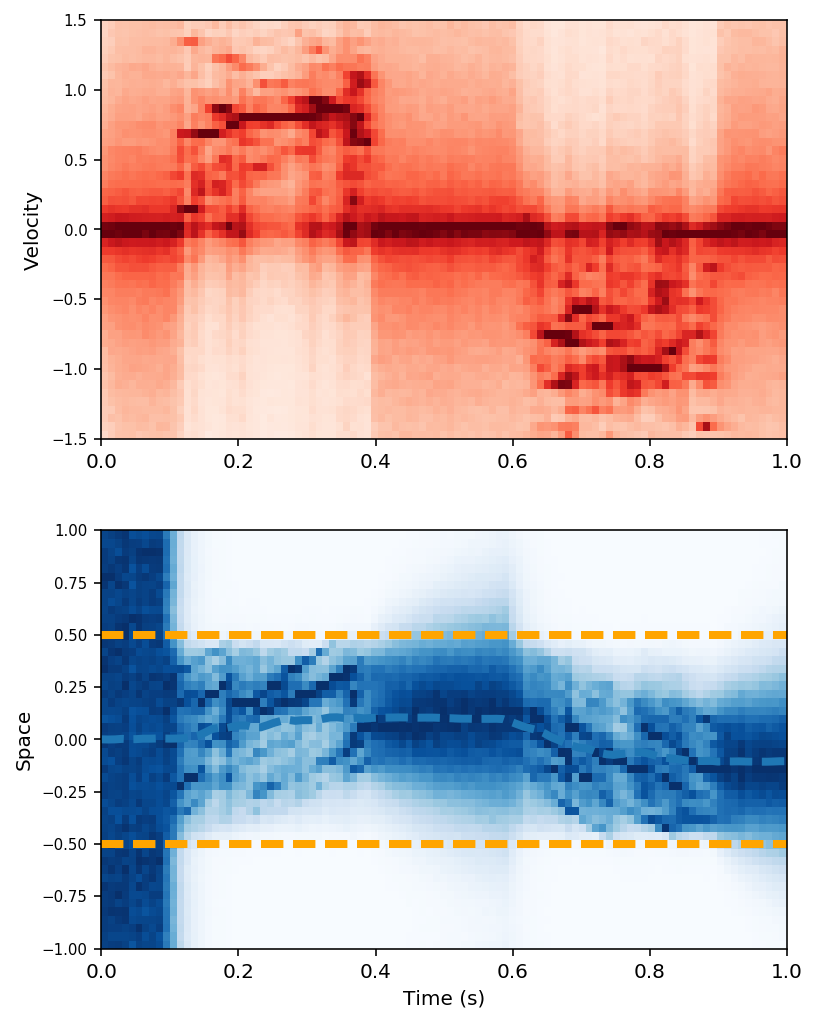

In [8]:
particles = image['result'][0].copy()    
fig, axs = mp.spatial_readout(particles, N_quant_X=N_quant, N_quant_Y=1, ruler=False)
average_pos = np.sum(v_hist*x_middle[:, np.newaxis], axis=0)
_ = axs[0].plot(time, average_pos, lw=4, ls='--')
_ = axs[0].plot([0, 1], [stim_size, stim_size], c='orange', lw=4, ls='--')
_ = axs[0].plot([0, 1], [-stim_size, -stim_size], c='orange', lw=4, ls='--')

As a conclusion, we observe a different behaviour in our predictive coding model than that observed in V1 and V3. It was to be expected mainly because we do not represent a neural activity but a probability (the a posteriori estimate) and that ---apart from the aperture which "explains away" motion--- our system is made to track motion and does it well in that case.

In contrast, what is observed in V1 (and following many of the predictive brain theories such as the free-energy account from Karl Friston), is reminiscent of some representation of the "surprise" between on one side the incoming stream of sensory input (and that is comprised in the above plot between the 2 orange horizontal lines) and on the other side the feedback stream from an area representing motion such as area MT.

Our posterior representation is certainly closer to the latter (MT). Even if we postulate that this area manages to fill-out the representation of motion within some of the disk aperture, we could thus think that the aperture inward bias is perhaps linked to the prediction error represented in V1 (that is to input confronted to this representation with an aperture-outward bias). This obviously needs more thinking to be made a scientific evidence :-)